# Los Angeles Crimes Analysis

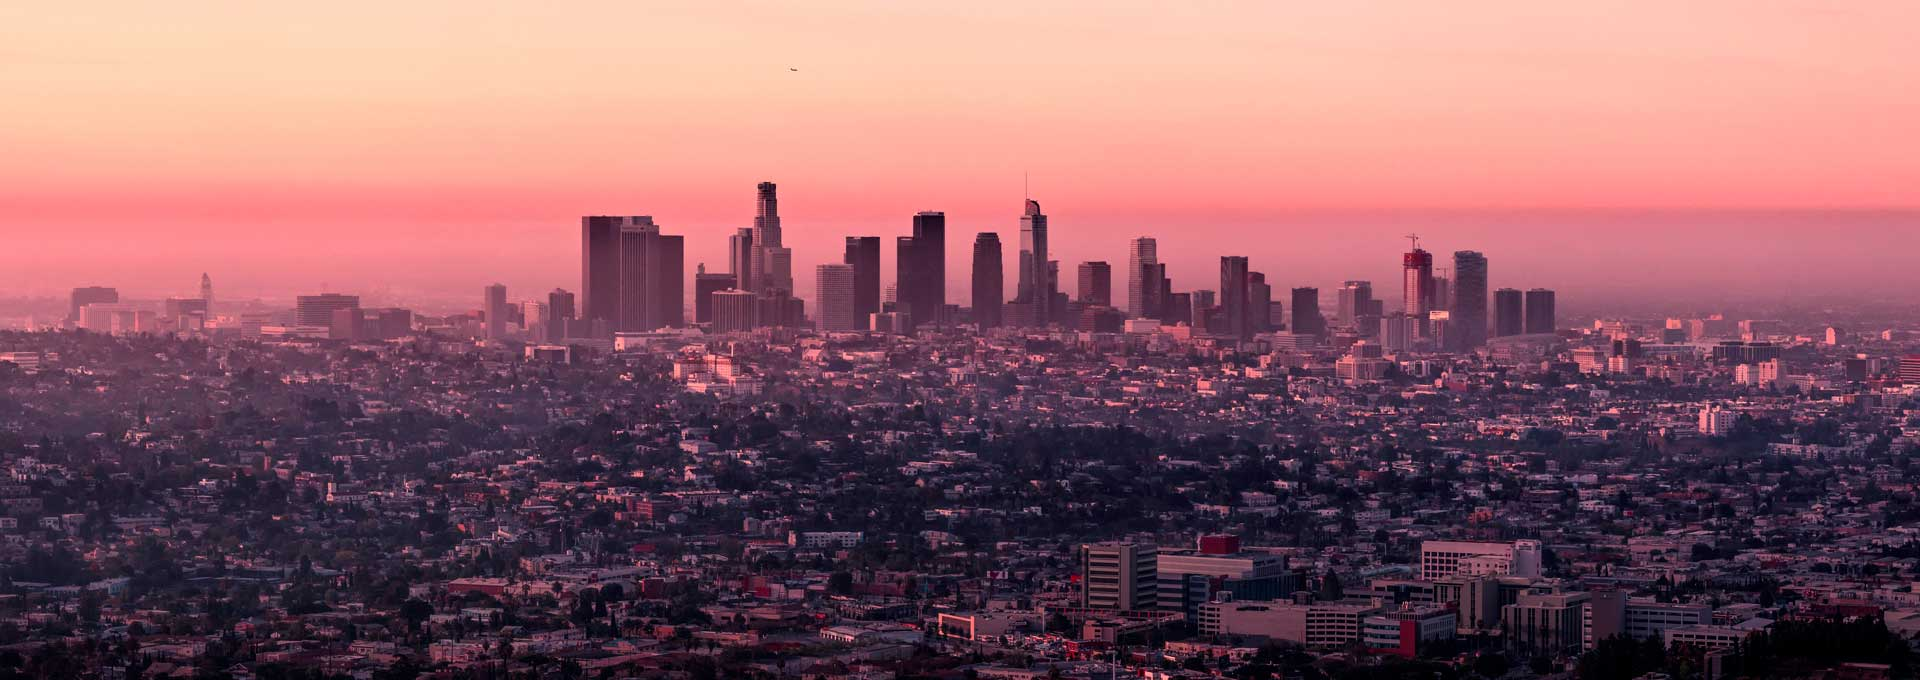


Los Angeles is a city of contrasts, where vibrant neighborhoods and cultural landmarks coexist with complex social issues. With a population of nearly four million people, it's no surprise that LA faces a wide range of criminal activities, from petty thefts to more serious offenses. The sheer diversity of its districts, each with its own unique challenges, makes it imperative to approach crime prevention with a data-driven strategy.

Our role is to delve into the crime data, dissecting it to uncover hidden trends and correlations. By examining when, where, and how crimes occur, we can provide the LAPD with actionable insights. This analysis will empower law enforcement to not only respond to incidents more efficiently but also to anticipate potential crime hotspots and deploy resources preemptively.

Whether it's identifying patterns in burglary rates across different neighborhoods, understanding the timing of certain crimes, or analyzing the demographics of victims and offenders, our analysis will be a vital tool in shaping the future of public safety in Los Angeles. Together, we can contribute to making LA a safer place for all its residents and visitors.

## The Data

 Los Angeles Police Department (LAPD) have provided us with a single dataset to use. A summary and preview are provided below.

It is a modified version of the original data, which is publicly available from Los Angeles Open Data.

# crimes.csv

| Column     | Description              |
|------------|--------------------------|
| `'DR_NO'` | Division of Records Number: Official file number made up of a 2-digit year, area ID, and 5 digits. |
| `'Date Rptd'` | Date reported - MM/DD/YYYY. |
| `'DATE OCC'` | Date of occurrence - MM/DD/YYYY. |
| `'TIME OCC'` | In 24-hour military time. |
| `'AREA NAME'` | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, the 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles. |
| `'Crm Cd Desc'` | Indicates the crime committed. |
| `'Vict Age'` | Victim's age in years. |
| `'Vict Sex'` | Victim's sex: `F`: Female, `M`: Male, `X`: Unknown. |
| `'Vict Descent'` | Victim's descent:<ul><li>`A` - Other Asian</li><li>`B` - Black</li><li>`C` - Chinese</li><li>`D` - Cambodian</li><li>`F` - Filipino</li><li>`G` - Guamanian</li><li>`H` - Hispanic/Latin/Mexican</li><li>`I` - American Indian/Alaskan Native</li><li>`J` - Japanese</li><li>`K` - Korean</li><li>`L` - Laotian</li><li>`O` - Other</li><li>`P` - Pacific Islander</li><li>`S` - Samoan</li><li>`U` - Hawaiian</li><li>`V` - Vietnamese</li><li>`W` - White</li><li>`X` - Unknown</li><li>`Z` - Asian Indian</li> |
| `'Weapon Desc'` | Description of the weapon used (if applicable). |
| `'Status Desc'` | Crime status. |
| `'LOCATION'` | Street address of the crime. |

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from datetime import timedelta


In [106]:
import requests
from io import StringIO

# Function to load all data from the open API
def fetch_all_data(base_url, limit=50000):
    offset = 0
    all_data = pd.DataFrame()
    
    while True:
        # Forming the URL with $limit and $offset parameters for data pagination
        url = f"{base_url}?$limit={limit}&$offset={offset}"
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        
        # Reading the data into a temporary DataFrame
        temp_data = pd.read_csv(StringIO(response.text), parse_dates=["date_rptd", "date_occ"], dtype={"time_occ": str})
        
        # Adding the temporary data to the main DataFrame
        all_data = pd.concat([all_data, temp_data], ignore_index=True)
        
        # If the number of rows received is less than the limit, it means we've got all the data
        if len(temp_data) < limit:
            break
        
        # Offset to the next set of data
        offset += limit
    
    return all_data

# Call the function to load all data
base_url = "https://data.lacity.org/resource/2nrs-mtv8.csv"
crimes = fetch_all_data(base_url)

# Function to clean the data
def clean_data(df):
    # Drop rows where critical columns contain NaN
    df = df.dropna(subset=["dr_no", "date_rptd", "date_occ", "crm_cd_desc"])
    
    # Convert date columns to datetime, drop rows with incorrect dates
    df["date_rptd"] = pd.to_datetime(df["date_rptd"], errors='coerce')
    df["date_occ"] = pd.to_datetime(df["date_occ"], errors='coerce')
    df = df.dropna(subset=["date_rptd", "date_occ"])  # Drop rows with incorrect dates

    # Remove extra spaces from time_occ and check the HHMM format
    df["time_occ"] = df["time_occ"].str.strip()
    df = df[df["time_occ"].str.match(r'^\d{4}$')]  # Keep rows with the correct time format (HHMM)

    # Convert time_occ to numeric format to handle incorrect time formats
    df["time_occ"] = pd.to_numeric(df["time_occ"], errors='coerce')
    df = df.dropna(subset=["time_occ"])  # Drop rows where time could not be converted

    # Map descent and sex values and drop rows with 'Unknown' values
    descent_mapping = {
        'A': 'Other Asian', 'B': 'Black', 'C': 'Chinese', 'D': 'Cambodian', 
        'F': 'Filipino', 'G': 'Guamanian', 'H': 'Hispanic/Latin/Mexican', 
        'I': 'American Indian/Alaskan Native', 'J': 'Japanese', 'K': 'Korean', 
        'L': 'Laotian', 'O': 'Other', 'P': 'Pacific Islander', 'S': 'Samoan', 
        'U': 'Hawaiian', 'V': 'Vietnamese', 'W': 'White', 'X': 'Unknown', 
        'Z': 'Asian Indian'
    }
    
    sex_mapping = {
        'F': 'Female', 'M': 'Male', 'X': 'Unknown'
    }

    # Apply mapping and drop rows with 'Unknown' values
    df['vict_descent'] = df['vict_descent'].map(descent_mapping).fillna('Unknown')
    df['vict_sex'] = df['vict_sex'].map(sex_mapping).fillna('Unknown')

    # Drop rows where 'vict_descent' or 'vict_sex' is 'Unknown'
    df = df[(df['vict_descent'] != 'Unknown') & (df['vict_sex'] != 'Unknown')]
    
    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)
    
    return df

# Call the data cleaning function
crimes = clean_data(crimes)

# Print the number of rows fetched
print(f"Total number of rows fetched: {len(crimes)}")

print("Dataset columns:")
print(", ".join(crimes.columns))

# Check the first few rows
crimes.head(10)

Total number of rows fetched: 732199
Dataset columns:
dr_no, date_rptd, date_occ, time_occ, area, area_name, rpt_dist_no, part_1_2, crm_cd, crm_cd_desc, mocodes, vict_age, vict_sex, vict_descent, premis_cd, premis_desc, weapon_used_cd, weapon_desc, status, status_desc, crm_cd_1, crm_cd_2, crm_cd_3, crm_cd_4, location, cross_street, lat, lon


,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1_2,crm_cd,crm_cd_desc,...,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon
0,190326475,2020-03-01,2020-03-01,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,2020-02-09,2020-02-08,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200907217,2023-05-10,2020-03-10,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
3,220614831,2022-08-18,2020-08-17,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277
4,231808869,2023-04-04,2020-12-01,2300,18,Southeast,1826,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,9900 COMPTON AV,NaN,33.9467,-118.2463
5,230110144,2023-04-04,2020-07-03,900,1,Central,182,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1100 S GRAND AV,NaN,34.0415,-118.2620
6,220314085,2022-07-22,2020-05-12,1110,3,Southwest,303,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,2500 S SYCAMORE AV,NaN,34.0335,-118.3537
7,231309864,2023-04-28,2020-12-09,1400,13,Newton,1375,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1300 E 57TH ST,NaN,33.9911,-118.2521
8,211904005,2020-12-31,2020-12-31,1220,19,Mission,1974,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,9000 CEDROS AV,NaN,34.2336,-118.4535
9,221804943,2022-01-21,2020-07-01,1335,18,Southeast,1822,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,100 W COLDEN AV,NaN,33.9492,-118.2739


In [107]:
# Read the crime categories from the text file
with open("crime_categories.txt", "r") as file:
    lines = file.readlines()

# Initialize the mapping dictionary
crime_category_mapping = {}
current_category = None

# Parse the file and build the mapping dictionary
for line in lines:
    line = line.strip()
    if not line:
        continue
    if line in ["Theft and Burglary", "Violent Crimes", "Sexual Crimes", "Fraud and Financial Crimes", 
                "Property and Vandalism Crimes", "Drug and Alcohol Crimes", "Miscellaneous Crimes", 
                "Traffic Violations and Vehicle Crimes", "Threats and Harassment", "Juvenile Crimes"]:
        current_category = line
    else:
        crime_category_mapping[line] = current_category

# Map the 'Crm Cd Desc' values to their respective categories
crimes['Crime_category'] = crimes['crm_cd_desc'].map(crime_category_mapping)
print("Dataset columns:")
print(", ".join(crimes.columns))

Dataset columns:
dr_no, date_rptd, date_occ, time_occ, area, area_name, rpt_dist_no, part_1_2, crm_cd, crm_cd_desc, mocodes, vict_age, vict_sex, vict_descent, premis_cd, premis_desc, weapon_used_cd, weapon_desc, status, status_desc, crm_cd_1, crm_cd_2, crm_cd_3, crm_cd_4, location, cross_street, lat, lon, Crime_category


##### Since we have categorized crimes into distinct categories, it is essential to begin our analysis by examining the distribution of crimes across these categories. Understanding how crimes are distributed among different categories will provide valuable insights into the prevalence of various types of criminal activities. 

## Crime distribution by category

In [108]:
# Group the data by crime category and count the occurrences
crime_counts_by_category = crimes['Crime_category'].value_counts()

# Create a bar chart
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=crime_counts_by_category.index,
        y=crime_counts_by_category.values,
        marker_color='indianred',  # Customize the color here
        hovertemplate=''  # Remove hover text
    )
)

# Add annotations (labels) above the bars
for i, value in enumerate(crime_counts_by_category.values):
    fig.add_annotation(
        x=crime_counts_by_category.index[i],
        y=value,
        text=str(value),
        showarrow=False,
        font=dict(size=14, color='black'),
        yshift=10  # Shift the label slightly above the bar
    )

# Customize the layout
fig.update_layout(
    title='Number of Crimes by Category',
    xaxis_title='Crime Category',
    yaxis_title='Number of Crimes',
    xaxis_tickfont_size=14,
    yaxis_tickfont_size=14,
    width=1000,
    height=600,
    showlegend=False  # Hide the legend
)

# Show the figure with config to disable interaction
fig.show(config={
    'staticPlot': True,  # Disables all interactive elements
    'displayModeBar': False,  # Disable the mode bar
    'scrollZoom': False,  # Disable scroll zoom
    'displaylogo': False,  # Disable Plotly logo
    'showSendToCloud': False,  # Hide send-to-cloud button
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the mode bar
})

#### Based on our chart, it's evident that the highest volume of crimes occurs in the "Theft and Burglary" and "Violent Crimes" categories. These categories represent the most significant areas of concern within the dataset. To gain a deeper understanding of the underlying factors contributing to these high crime rates, we need to explore these categories in more detail.


In [131]:
# Filter the data for "Theft and Burglary" category
theft_burglary_crimes = crimes[crimes['Crime_category'] == "Theft and Burglary"]

# Group the data by 'crm_cd_desc' and count the occurrences
theft_burglary_counts = theft_burglary_crimes['crm_cd_desc'].value_counts()

# Create a bar chart
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=theft_burglary_counts.index,
        y=theft_burglary_counts.values,
        marker_color='indianred'  # Customize the color here
    )
)

# Add annotations (labels) above the bars
for i, value in enumerate(theft_burglary_counts.values):
    fig.add_annotation(
        x=theft_burglary_counts.index[i],
        y=value,
        text=str(value),
        showarrow=False,
        font=dict(size=14, color='black'),
        yshift=10  # Shift the label slightly above the bar
    )

# Customize the layout
fig.update_layout(
    title='Crimes in "Theft and Burglary" Category',
    xaxis_title='Crime Description',
    yaxis_title='Number of Crimes',
    xaxis_tickfont_size=14,
    yaxis_tickfont_size=14,
    width=1565,
    height=1300
)

# Show the figure with config to disable interaction
fig.show(config={
    'staticPlot': True,  # Disables all interactive elements
    'displayModeBar': False,  # Disable the mode bar
    'scrollZoom': False,  # Disable scroll zoom
    'displaylogo': False,  # Disable Plotly logo
    'showSendToCloud': False,  # Hide send-to-cloud button
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the mode bar
})

The graph reveals that the highest number of crimes is concentrated in two categories: "Identity Theft" and "Burglary from Vehicle." These categories dominate the crime statistics, indicating that these types of offenses are the most frequent in the dataset.

Close behind, we see the "Petty Theft" category, which involves thefts of amounts up to $950. This category also shows a significant number of incidents, highlighting its notable presence in the overall crime data.

In [132]:
# Filter the data for "Theft and Burglary" category
theft_burglary_crimes = crimes[crimes['Crime_category'] == "Violent Crimes"]

# Group the data by 'crm_cd_desc' and count the occurrences
theft_burglary_counts = theft_burglary_crimes['crm_cd_desc'].value_counts()

# Create a bar chart
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=theft_burglary_counts.index,
        y=theft_burglary_counts.values,
        marker_color='indianred',  # Customize the color here
        hovertemplate='%{x}<br>Crimes: %{y:}<extra></extra>',  # Hover text
    )
)

# Add annotations (labels) above the bars
for i, value in enumerate(theft_burglary_counts.values):
    fig.add_annotation(
        x=theft_burglary_counts.index[i],
        y=value,
        text=str(value),
        showarrow=False,
        font=dict(size=14, color='black'),
        yshift=10,  # Shift the label slightly above the bar
    )

# Customize the layout
fig.update_layout(
    title='Crimes in "Violent Crimes" Category',
    xaxis_title='Crime Description',
    yaxis_title='Number of Crimes',
    xaxis_tickfont_size=14,
    yaxis_tickfont_size=14,
    width=1200,
    height=900,
    hoverlabel=dict(
        font_size=14,
        font_family='Arial'
    ),
)

# Show the figure with config to disable interaction
fig.show(config={
    'staticPlot': True,  # Disables all interactive elements
    'displayModeBar': False,  # Disable the mode bar
    'scrollZoom': False,  # Disable scroll zoom
    'displaylogo': False,  # Disable Plotly logo
    'showSendToCloud': False,  # Hide send-to-cloud button
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the mode bar
})

The graph reveals that the most prevalent crimes fall under the category of "Battery - Simple Assault," which involves instances of physical harm inflicted without the use of a weapon. This category represents a significant portion of the overall crime data.

Close behind are the combined categories of "Assault with Deadly Weapon and Aggravated Assault." These encompass serious offenses where either a weapon is used or severe injury is inflicted, representing another substantial share of the crime incidents.

Additionally, the "Intimate Partner - Simple Assault" category ranks closely behind. This category highlights offenses related to physical attacks occurring within intimate relationships, indicating a notable frequency of domestic violence-related incidents.

## Geographic Distribution of Crimes

To gain a comprehensive understanding of crime patterns, it is essential to examine both the locations where crimes occur and the times at which they take place. By analyzing the geographical distribution and the time of day for each incident, we can identify key areas with high crime rates and understand the temporal aspects of criminal activity. 

In [111]:
# Create a 'DATETIME OCC' column with proper formatting
def format_datetime(row):
    if pd.notna(row['date_occ']) and pd.notna(row['time_occ']):
        time_str = str(int(row['time_occ'])).zfill(4)  # Ensure TIME OCC is a string with leading zeros if needed
        return f"{row['date_occ'].strftime('%d.%m.%Y')} {time_str[:2]}:{time_str[2:]}"
    return None

crimes['DATETIME OCC'] = crimes.apply(format_datetime, axis=1)

# Extract hour from TIME OCC
crimes['Hour OCC'] = pd.to_numeric(crimes['time_occ'].astype(str).str[:2], errors='coerce')

# Calculate the frequency of crimes by area
area_crime_counts = crimes['area_name'].value_counts()

# Find the area with the largest frequency of crimes
peak_crime_location = area_crime_counts.idxmax()
peak_crime_count = area_crime_counts.max()

print(f"Peak crime location: {peak_crime_location} with {peak_crime_count} crimes")

Peak crime location: Central with 52563 crimes


### For greater clarity, we will create an interactive map of Los Angeles on which we will plot all crimes by year, month and day.

Let's start by getting the necessary data in the variable

In [112]:
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Load and format the dataset
crimes['date_occ'] = pd.to_datetime(crimes['date_occ'], errors='coerce')
crimes['time_occ'] = crimes['time_occ'].astype(str).str.strip().str.zfill(4)


# Clean up the location field
crimes['location'] = crimes['location'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Extract the year, month, and day from the date_occ column
crimes['Year'] = crimes['date_occ'].dt.year
crimes['Month'] = crimes['date_occ'].dt.month
crimes['Day'] = crimes['date_occ'].dt.day  

# Define day and night based on time_occ
def get_daypart(time_str):
    hour = int(time_str[:2])
    if 7 <= hour < 21:
        return 'Day'
    elif 0 <= hour < 7 or 21 <= hour < 24:
        return 'Night'
    return 'Unknown'

crimes['Daypart'] = crimes['time_occ'].apply(lambda x: get_daypart(x) if pd.notna(x) else 'Unknown')

For clarity, we need to download a file containing the border of Los Angeles. After comparing whether the coordinates of the border from the file and the coordinates of the values ​​of our data are the same, you can proceed to the widget settings so that the user can sort the data, due to their excessive amount. After that, we will add data to the graph that will be highlighted after pointing to the point responsible for the crime, there the user will be able to see the type of crime, the date when the crime was committed, information about the victim and the place of the crime.

In [113]:
# Convert the GeoDataFrames to DataFrames for Plotly
crimes_gdf = gpd.GeoDataFrame(
    crimes, 
    geometry=gpd.points_from_xy(crimes['lon'], crimes['lat']),
    crs="EPSG:4326"  # Assuming the coordinates are in WGS84
)
crimes_df = pd.DataFrame(crimes_gdf)

# Load the shapefile for Los Angeles
shapefile_path = "LA shapefile data/los-angeles-city-boundary.shp"
la_boundaries = gpd.read_file(shapefile_path)

# Ensure the CRS of the shapefile and crime data are the same
if la_boundaries.crs != crimes_gdf.crs:
    la_boundaries = la_boundaries.to_crs(crimes_gdf.crs)

# Convert the GeoDataFrames to DataFrames for Plotly
boundaries_df = pd.DataFrame(la_boundaries)

# Extract the bounding box of LA for setting map boundaries
min_lon, min_lat, max_lon, max_lat = la_boundaries.total_bounds

# Define buffer percentages to control the extent
lon_buffer_percentage = 0.1541  # buffer for longitude
lat_buffer_percentage = 0.01    # buffer for latitude

# Calculate the buffer in terms of latitude and longitude
lon_buffer = (max_lon - min_lon) * lon_buffer_percentage
lat_buffer = (max_lat - min_lat) * lat_buffer_percentage

# Adjust the bounding box by adding the buffer
min_lon -= lon_buffer
max_lon += lon_buffer
min_lat -= lat_buffer
max_lat += lat_buffer

# Calculate the center of the map
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

# Define the default value that will not be an option
default_value = 'Please Select'

# Define the widgets for year, month, day, and daypart selection
year_widget = widgets.Dropdown(
    options=[option for option in sorted(crimes_df['Year'].unique())],  
    description='Year:',
    value=None  # Default value is not an option
)

month_widget = widgets.Dropdown(
    options=['All'],  # Will be updated based on available data
    description='Month:',
    value=None  # Default value is not an option
)

day_widget = widgets.Dropdown(
    options=['All'],  # Will be updated based on available data
    description='Day:',
    value=None  # Default value is not an option
)

daypart_widget = widgets.Dropdown(
    options=['All'],  # Will be updated based on available data
    description='Daypart:',
    value=None  # Default value is not an option
)

# Create an Output widget for displaying the map with specific dimensions
map_output = widgets.Output()

# Create a Label widget for showing the crime count
crime_count_label = widgets.Label(value="Crime Count: 0")

# Function to update month, day, and daypart widget options based on the selected year and month
def update_widgets(year, month):
    if year is not None:
        filtered_crimes = crimes_df[crimes_df['Year'] == year]
        
        # Update month widget options based on available months in the filtered data
        available_months = sorted(filtered_crimes['Month'].unique())
        month_widget.options = ['All'] + [month_names[m] for m in available_months]
        
        if month != 'All':
            # Filter by the selected month
            month_number = [num for num, name in month_names.items() if name == month]
            if month_number:
                filtered_crimes = filtered_crimes[filtered_crimes['Month'] == month_number[0]]
        
        # Update day widget options based on available days in the filtered data
        available_days = sorted(filtered_crimes['Day'].unique())
        day_widget.options = ['All'] + available_days
        
        # Update daypart widget options based on available dayparts in the filtered data
        available_dayparts = sorted(filtered_crimes['Daypart'].unique())
        daypart_widget.options = ['All'] + available_dayparts

# Define a function to update the map based on widget values
def update_map(year, month, day, daypart):
    with map_output:
        clear_output(wait=True)
        
        # Check if year, month, day, and daypart filters have valid selections
        if year is None or month is None or day is None or daypart is None:
            print("Please select a year, month, day, and daypart to display the map.")
            return
        
        # Convert month name back to number for filtering
        month_number = [num for num, name in month_names.items() if name == month]
        
        # Filter data based on widget values
        filtered_crimes = crimes_df[crimes_df['Year'] == year]
        
        if month != 'All' and month_number:
            filtered_crimes = filtered_crimes[filtered_crimes['Month'] == month_number[0]]
        
        # Apply day filter if not 'All'
        if day != 'All':
            filtered_crimes = filtered_crimes[filtered_crimes['Day'] == day]
        
        # Apply daypart filter if not 'All'
        if daypart != 'All':
            filtered_crimes = filtered_crimes[filtered_crimes['Daypart'] == daypart]

        # Update crime count label
        crime_count_label.value = f"Crime Count: {len(filtered_crimes)}"
        
        # Create an interactive scatter mapbox plot for crimes
        fig = px.scatter_mapbox(
            filtered_crimes, 
            lat="lat", 
            lon="lon", 
            hover_name="crm_cd_desc", 
            hover_data={
                "DATETIME OCC": True, 
                "vict_descent": True,
                "vict_sex": True,
                "vict_age": True,
                "location": True        
            },
            color_discrete_sequence=["darkred"], 
            height=1000,  # Adjusted height
            width=900,   # Adjusted width
            center={"lat": center_lat, "lon": center_lon},   
        )

        # Add boundaries to the map
        for _, row in boundaries_df.iterrows():
            coords = list(row['geometry'].exterior.coords)
            lon, lat = zip(*coords)  # Unzip into separate lists
            fig.add_scattermapbox(
                lat=lat,
                lon=lon,
                mode='lines',
                line=dict(width=1.5, color='blue'),
                name='LA Boundaries',
                hoverinfo='none' 
            )

        # Set the mapbox style to "open-street-map"
        fig.update_layout(mapbox_style="open-street-map")

        # Set the title and remove the legend
        fig.update_layout(
            title="Locations of crimes in Los Angeles",
            legend=dict(visible=False)  # Hiding the legend
        )

        # Restrict the map to the adjusted bounding box of Los Angeles
        fig.update_layout(
            mapbox=dict(
                center={"lat": center_lat, "lon": center_lon},
                style="open-street-map",
                # Setting the expanded bounding box limits
                bounds=dict(
                    west=min_lon,
                    east=max_lon,
                    south=min_lat,
                    north=max_lat
                )
            )
        )

        # Update hover label appearance
        fig.update_layout(
            hoverlabel=dict(
                bgcolor='rgba(255, 255, 255, 0.8)',  # Background color of the hover panel
                font_color='black',  # Font color of the hover text
                font_size=12  # Font size of the hover text
            )
        )

        # If no data is available, display a blank map
        if filtered_crimes.empty:
            fig.update_layout(title="No Data Available for Selected Filters")

        # Display the updated map
        fig.show()

# Function to handle changes in year and month widgets
def handle_widget_change(change):
    year = year_widget.value
    month = month_widget.value
    day = day_widget.value
    daypart = daypart_widget.value

    # Reset month, day, and daypart when year changes
    if change['name'] == 'value' and change['owner'] == year_widget:
        month_widget.value = None
        day_widget.value = None
        daypart_widget.value = None
        update_widgets(year_widget.value, month_widget.value)
    
    # Reset day and daypart when month changes
    if change['name'] == 'value' and change['owner'] == month_widget:
        day_widget.value = None
        daypart_widget.value = None
        update_widgets(year_widget.value, month_widget.value)

# Attach observers to update widgets when year or month changes
year_widget.observe(handle_widget_change, names='value')
month_widget.observe(handle_widget_change, names='value')

# Display widgets and create an interactive output
ui = widgets.VBox([year_widget, month_widget, day_widget, daypart_widget, crime_count_label], layout=widgets.Layout(width='800px'))
display(ui, map_output)

# Create an interactive output that updates the map based on widget values
widgets.interactive_output(update_map, {'year': year_widget, 'month': month_widget, 'day': day_widget, 'daypart': daypart_widget})

Output()

Output()

## Temporal dynamics of crimes

In [114]:
# Find the hour with the highest frequency of crimes
peak_crime_hour = crimes['Hour OCC'].mode()[0]
print(f"Peak crime hour : {peak_crime_hour}")

Peak crime hour : 12


To gain a clearer understanding of how crime numbers vary throughout the day, we'll create a visualization that illustrates this relationship. We opted to use a color gradient inspired by the sun's cycle to represent the number of crimes per hour.

In [115]:
# Extract hour from TIME OCC and ensure it's within the range 0-23
crimes['Hour OCC'] = pd.to_numeric(crimes['time_occ'].str[:2], errors='coerce')
crimes = crimes[crimes['Hour OCC'].between(0, 23)]

# Group the data by 'Hour OCC' and 'Crime_category'
hourly_crime_counts = crimes.groupby(['Hour OCC', 'Crime_category']).size().unstack(fill_value=0)

# Calculate the total number of crimes per hour
total_crimes_per_hour = hourly_crime_counts.sum(axis=1)

In [116]:
# Prepare data for Plotly
data = []
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

for i, category in enumerate(hourly_crime_counts.columns):
    data.append(
        go.Bar(
            x=hourly_crime_counts.index,
            y=hourly_crime_counts[category].astype(int),
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],  # Assign color from palette
            hovertemplate='Hour: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',  # Tooltip background color
                font_size=14,     # Tooltip font size
                font_family='Arial',  # Tooltip font
            ),
        )
    )

# Create layout for Plotly
layout = go.Layout(
    title='Crimes Committed by Hour',
    xaxis=dict(
        title='Hour of the Day',
        tickvals=np.arange(24),
        ticktext=np.arange(24),
        tickfont=dict(size=16),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
    ),
    barmode='stack',
    width=1500,  # Width of the plot
    height=900,  # Height of the plot
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disables clicking to hide categories in the legend
        itemdoubleclick=False  # Disables double-clicking to hide categories in the legend
    ),
    dragmode=False,  # Disables zooming on the plot
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Add annotations with total number of crimes above each bar
for hour in hourly_crime_counts.index:
    total_crimes = total_crimes_per_hour[hour]
    fig.add_annotation(
        x=hour,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Show the plot with interaction features disabled
fig.show(config={
    'displayModeBar': False,  # Disables the top toolbar
    'scrollZoom': False,  # Disables zooming with scroll
    'displaylogo': False,  # Disables Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Removes specific buttons from the toolbar
})

#### Continuing to study the temporal dynamics of crimes, it is important to check whether there is a fundamental change in the number of crimes depending on the day of the week.

In [117]:
# Adding a column with the day of the week
crimes['DAY_OF_WEEK'] = crimes['date_occ'].dt.day_name()

# Counting the number of crimes for each day of the week, breaking them down by crime category
crime_counts_by_day = crimes.groupby(['DAY_OF_WEEK', 'Crime_category']).size().unstack(fill_value=0)

# Rearranging the days of the week
crime_counts_by_day = crime_counts_by_day.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Calculating the total number of crimes for each day
total_crimes_per_day = crime_counts_by_day.sum(axis=1)


In [118]:
# Defining a color palette
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

# Preparing data for Plotly
data = []
for i, category in enumerate(crime_counts_by_day.columns):
    data.append(
        go.Bar(
            x=crime_counts_by_day.index,
            y=crime_counts_by_day[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],  # Assigning colors from the palette
            hovertemplate='Day: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',  # Tooltip background color
                font_size=14,     # Tooltip font size
                font_family='Arial',  # Tooltip font
            ),
        )
    )

# Creating the layout for Plotly
layout = go.Layout(
    title='Crimes Committed by Days of the Week',
    xaxis=dict(
        title='Day of the Week',
        tickvals=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        tickfont=dict(size=16),
        titlefont=dict(size=20)
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
    ),
    barmode='stack',
    width=1200,  # Chart width
    height=800,  # Chart height
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disables category toggling by clicking on the legend
        itemdoubleclick=False  # Disables double-clicking on the legend
    ),
    dragmode=False,  # Disables panning and zooming
)

# Creating the figure
fig = go.Figure(data=data, layout=layout)

# Adding annotations with the total number of crimes above each bar
for day in crime_counts_by_day.index:
    total_crimes = total_crimes_per_day[day]
    fig.add_annotation(
        x=day,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Displaying the chart with interaction features disabled
fig.show(config={
    'displayModeBar': False,  # Disables the top toolbar
    'scrollZoom': False,  # Disables zooming with the scroll
    'displaylogo': False,  # Disables the Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Removes specific buttons from the toolbar
})

An analysis of the number of crimes by day of the week shows that there is generally no significant variation in the number of crimes between different days. However, it is important to note that there is a significant difference in the number of crimes between Thursday and Friday. On Thursday, 78457 crimes were reported, while on Friday, 83747 crimes were reported. 

This significant difference may indicate specific events or factors that affect the number of crimes at the end of the week.

#### Given the distribution of crimes across different days and hours, it is essential to examine how these trends shift throughout the year, considering the varying seasons and their impact on criminal activity. By analyzing the data, we can uncover how crime patterns evolve from one season to another, providing valuable insights into the temporal dynamics of criminal behavior.

In [119]:
# Function to determine the season
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

crimes['Season'] = crimes['date_occ'].apply(get_season)

# Analyzing crime counts by seasons
seasonal_trends = crimes.groupby('Season').size().reset_index(name='Crime Count')
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_trends['Season'] = pd.Categorical(seasonal_trends['Season'], categories=season_order, ordered=True)
seasonal_trends = seasonal_trends.sort_values('Season')



In [120]:
# Custom order for seasons
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Transforming data for the bar chart with custom season order
seasonal_trends = crimes.groupby(['Season', 'Crime_category']).size().unstack(fill_value=0)
seasonal_trends = seasonal_trends.reindex(season_order)

# Preparing data for Plotly
data = []
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

# Preparing data for Plotly
data = []
for i, category in enumerate(seasonal_trends.columns):
    data.append(
        go.Bar(
            x=seasonal_trends.index,
            y=seasonal_trends[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],
            hovertemplate='Season: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',
                font_size=14,
                font_family='Arial',
            ),
        )
    )

# Creating the layout for Plotly
layout = go.Layout(
    title='Crimes Committed During the Season',
    xaxis=dict(
        title='Season',
        tickvals=seasonal_trends.index,
        tickfont=dict(size=14),  # X-axis tick label size
        titlefont=dict(size=16),  # X-axis title size
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=16),  # Y-axis title size
        tickfont=dict(size=14),  # Y-axis tick label size
    ),
    barmode='stack',
    width=1200,  # Chart width
    height=900,  # Chart height
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disable category toggling by clicking on the legend
        itemdoubleclick=False  # Disable double-clicking on the legend
    ),
    dragmode=False,  # Disable panning and zooming
)

# Creating the figure
fig = go.Figure(data=data, layout=layout)

# Adding the total number of crimes above each bar
for i, season in enumerate(seasonal_trends.index):
    total_crimes = seasonal_trends.loc[season].sum()
    fig.add_annotation(
        x=season,
        y=total_crimes,
        text=f'{int(total_crimes)}',  # Display the total number as an integer
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Displaying the chart with interaction features disabled
fig.show(config={
    'displayModeBar': False,  # Disables the top toolbar
    'scrollZoom': False,  # Disables zooming with the scroll
    'displaylogo': False,  # Disables the Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Removes specific buttons from the toolbar
})

##### Seasonal Crime Trends:

Plot reveals a noticeable seasonal pattern in crime rates. Crime activity tends to be highest in winter, with 146,805 recorded incidents, followed closely by autumn with 145,653 crimes. As the year progresses, a decline in crime is observed, with summer recording 138,332 crimes, and the lowest crime rate occurring in spring at 129,146 incidents. This trend suggests that crime decreases as the seasons shift from colder to warmer months.

#### It's also crucial to examine how crime rates fluctuate around holidays. Certain holidays can contribute to a spike in thefts and similar offenses, as they often involve large gatherings, increased consumer spending, and other activities that may create opportunities for criminal behavior. By analyzing the changes in crime patterns during these periods, we can better understand the impact of holidays on criminal activity and develop strategies to mitigate these risks.

In [121]:
# List of holidays without the year
us_holidays = {
    'New Year\'s Day': '01-01',
    'Martin Luther King Jr. Day': '01-15',
    'Presidents\' Day': '02-19',
    'Memorial Day': '05-28',
    'Independence Day': '07-04',
    'Labor Day': '09-03',
    'Veterans Day': '11-11',
    'Thanksgiving': '11-22',
    'Christmas Day': '12-25',
    'Easter': '04-01',
    'St. Patrick\'s Day': '03-17',
    'Halloween': '10-31',
    'Columbus Day': '10-08',
    'Good Friday': '03-30',
    'Black Friday': None  # Black Friday will be handled separately
}

# Function to determine if a date is a holiday, considering the year
def is_holiday(date):
    year = date.year  # Extracting the year from the date
    for name, holiday_date in us_holidays.items():
        if holiday_date:
            # Creating a holiday date with the year
            holiday_datetime = pd.Timestamp(f'{year}-{holiday_date}')
            if date == holiday_datetime:
                return name
        else:
            # Handling Black Friday
            thanksgiving = pd.Timestamp(year, 11, 1) + pd.DateOffset(weeks=3, weekday=4)  # Fourth Thursday of November
            black_friday_start = thanksgiving + timedelta(days=1)
            black_friday_end = black_friday_start + timedelta(days=6)
            if black_friday_start <= date <= black_friday_end:
                return 'Black Friday'
    return 'None'

# Adding holiday information to the DataFrame
crimes['Holiday'] = crimes['date_occ'].apply(is_holiday)

# Analyzing the number of crimes on holidays
holiday_crimes = crimes[crimes['Holiday'] != 'None'].groupby('Holiday').size().reset_index(name='Crime Count')

# Creating holiday dates for each unique year in the data
holiday_dates = {}
for year in crimes['date_occ'].dt.year.unique():
    for name, date_str in us_holidays.items():
        if date_str:
            holiday_dates[(name, year)] = pd.Timestamp(f'{year}-{date_str}')
    # Updating the year for Black Friday
    thanksgiving = pd.Timestamp(year, 11, 1) + pd.DateOffset(weeks=3, weekday=4)
    holiday_dates[('Black Friday', year)] = thanksgiving + timedelta(days=1)

# Sorting holidays by date
sorted_holidays = sorted(holiday_dates.items(), key=lambda x: x[1])
sorted_holiday_names = [name for (name, _), _ in sorted_holidays]

# Transforming data for the bar chart
holiday_crimes = crimes[crimes['Holiday'] != 'None'].groupby(['Holiday', 'Crime_category']).size().unstack(fill_value=0)

# Creating a DataFrame for holidays with dates
holiday_dates = {name: pd.Timestamp(f'2023-{date}') for name, date in us_holidays.items() if date}
holiday_dates['Black Friday'] = pd.Timestamp('2023-11-01') + pd.DateOffset(weeks=3, weekday=4) + timedelta(days=1)  # First day of Black Friday

# Adding dates to the DataFrame
holidays_df = pd.DataFrame(list(holiday_dates.items()), columns=['Holiday', 'Date'])
holidays_df = holidays_df.set_index('Holiday')

# Sorting holidays by date
holidays_df = holidays_df.sort_values(by='Date')

# Getting sorted holiday names
sorted_holidays = holidays_df.index.tolist()

# Reordering holiday_crimes to match sorted holidays
holiday_crimes = holiday_crimes.reindex(sorted_holidays)

In [122]:
# Defining the color palette
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

# Preparing data for Plotly
data = []
for i, category in enumerate(holiday_crimes.columns):
    data.append(
        go.Bar(
            x=holiday_crimes.index,
            y=holiday_crimes[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],
            hovertemplate='Holiday: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',
                font_size=14,
                font_family='Arial',
            ),
        )
    )

# Creating the layout for Plotly
layout = go.Layout(
    title='Crimes Committed on Holidays',
    xaxis=dict(
        title='Holiday',
        tickvals=list(holiday_crimes.index),
        ticktext=[name if name != 'Black Friday' else 'Black Friday' for name in holiday_crimes.index],
        tickfont=dict(size=16),
        titlefont=dict(size=20),
        tickangle=-45,
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
    ),
    barmode='stack',
    width=1200,
    height=800,
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disables clicking on legend items
        itemdoubleclick=False,  # Disables double-clicking on legend items
    ),
)

# Creating the figure
fig = go.Figure(data=data, layout=layout)

# Adding total number of crimes above each column
for holiday in holiday_crimes.index:
    total_crimes = holiday_crimes.loc[holiday].sum()
    fig.add_annotation(
        x=holiday,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Displaying the plot with disabled interaction features
fig.show(config={
    'displayModeBar': False,  # Disables the top toolbar
    'scrollZoom': False,  # Disables zooming with the scroll wheel
    'displaylogo': False,  # Disables the Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Removes specific buttons from the toolbar
})

Given that Black Friday spans an entire week, it’s essential to take a closer look at how the number of crimes fluctuates during this period.

In [123]:
# Defining Black Friday days for all years
black_friday_days = {}

for year in crimes['date_occ'].dt.year.unique():
    thanksgiving = pd.Timestamp(year, 11, 1) + pd.DateOffset(weeks=3, weekday=4)
    for i in range(7):
        day_label = f'BF day {i + 1}'
        black_friday_days[(year, day_label)] = thanksgiving + timedelta(days=i+1)

# Adding new Black Friday day labels to the DataFrame
def get_black_friday_day(date):
    year = date.year
    for day_label in [f'BF day {i + 1}' for i in range(7)]:
        if black_friday_days[(year, day_label)] == date:
            return day_label
    return None

crimes['Black_Friday_Day'] = crimes['date_occ'].apply(get_black_friday_day)

# Filtering the data for only Black Friday days
black_friday_crimes = crimes[crimes['Black_Friday_Day'].notnull()]

# Grouping the data by Black Friday days and crime categories
bf_trends = black_friday_crimes.groupby(['Black_Friday_Day', 'Crime_category']).size().unstack(fill_value=0)

In [124]:
# Defining the color palette
custom_colors = ["#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

# Preparing data for Plotly
data = []
for i, category in enumerate(bf_trends.columns):
    data.append(
        go.Bar(
            x=bf_trends.index,
            y=bf_trends[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],
            hovertemplate='Day: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',
                font_size=14,
                font_family='Arial',
            ),
        )
    )

# Creating layout for the plot
layout = go.Layout(
    title='Crimes committed during Black Friday',
    xaxis=dict(
        title='Black Friday Days',
        tickvals=list(bf_trends.index),
        ticktext=list(bf_trends.index),  # Labels for the X-axis
        tickfont=dict(size=16),  # Font size for the X-axis
        titlefont=dict(size=20),  # Font size for the X-axis title
        tickangle=-45,  # Tilt labels for better visibility
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),  # Font size for the Y-axis title
        tickfont=dict(size=16),  # Font size for the Y-axis
    ),
    barmode='stack',
    width=1200,  # Plot width
    height=800,  # Plot height
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disable clicking on legend items
        itemdoubleclick=False,  # Disable double-clicking on legend items
    ),
)

# Creating the figure
fig = go.Figure(data=data, layout=layout)

# Adding total crimes annotation above each bar
for day in bf_trends.index:
    total_crimes = bf_trends.loc[day].sum()
    fig.add_annotation(
        x=day,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Displaying the plot with disabled interaction features
fig.show(config={
    'displayModeBar': False,  # Disable the top toolbar
    'scrollZoom': False,  # Disable zooming with the scroll wheel
    'displaylogo': False,  # Remove Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the toolbar
})

##### Holiday Crime Trends:
Regarding crimes on holidays, Black Friday stands out as the day with the highest number of reported crimes. However, it's important to note that the data for Black Friday includes a full week of incidents, reflecting its status as a week-long event in the U.S. The second-highest number of crimes occurs on New Year’s Day, highlighting it as another period of increased criminal activity.

The crime trend during Black Friday shows an upward trajectory, indicating that the extended holiday period may contribute to a sustained increase in criminal activity. This pattern emphasizes the need for heightened vigilance and potentially increased law enforcement presence during these periods to manage the rise in crime effectively.

## Demographic Analysis of Crime Victims

Understanding the demographic characteristics of crime victims is essential for identifying patterns and disparities in how different populations are affected by crime. By analyzing data on the age, gender, and ethnicity of victims, we can uncover trends that may indicate specific groups are more vulnerable or targeted.

In [133]:
# Define age bins and labels
age_bins = [0, 17, 25, 34, 44, 54, 64, np.inf]
age_labels = ["0-17", "18-25", "26-34", "35-44", "45-54", "55-64", "65+"]

# Convert victim age into age groups
crimes['Victim Age Group'] = pd.cut(crimes['vict_age'], bins=age_bins, labels=age_labels, right=True)

# Grouping the data by age group and crime category
age_crime_data = crimes.groupby(['Victim Age Group', 'Crime_category'], observed=False).size().unstack(fill_value=0)

# Preparing data for Plotly
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

In [134]:
# Creating the initial figure
fig = go.Figure()

for i, category in enumerate(age_crime_data.columns):
    fig.add_trace(go.Bar(
        x=age_crime_data.index,
        y=age_crime_data[category],
        name=category,
        marker_color=custom_colors[i % len(custom_colors)],
        hovertemplate='Age Group: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
        hoverlabel=dict(
            bgcolor='white',
            font_size=14,
            font_family='Arial',
        ),
    ))

# Initializing the layout of the chart
fig.update_layout(
    title='Crime Count by Victim Age Group and Crime Category',
    xaxis=dict(
        title='Victim Age Group',
        tickvals=list(age_crime_data.index),
        ticktext=list(age_crime_data.index),
        tickfont=dict(size=16),
        titlefont=dict(size=20),
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),
        tickfont=dict(size=16),
    ),
    barmode='stack',
    width=1200,
    height=800,
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disable clicking on legend items
        itemdoubleclick=False,  # Disable double-clicking on legend items
    ),
    dragmode=False,  # Disables zoom on the chart
)

# Adding annotations with totals
annotations = []
for age_group in age_crime_data.index:
    total_crimes = age_crime_data.loc[age_group].sum()
    annotations.append(dict(
        x=age_group,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    ))

fig.update_layout(annotations=annotations)

# Displaying the plot with disabled interaction features
fig.show(config={
    'displayModeBar': False,  # Disable the top toolbar
    'scrollZoom': False,  # Disable zooming with the scroll wheel
    'displaylogo': False,  # Remove Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the toolbar
})

In [127]:
# Group the data by victim sex and crime category
sex_crime_data = crimes.groupby(['vict_sex', 'Crime_category'], observed=False).size().unstack(fill_value=0)

# Define the color palette
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

In [128]:
# Prepare data for Plotly
data = []
for i, category in enumerate(sex_crime_data.columns):
    data.append(
        go.Bar(
            x=sex_crime_data.index,
            y=sex_crime_data[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],
            hovertemplate='Sex: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',
                font_size=14,
                font_family='Arial',
            ),
        )
    )

# Create the layout for Plotly
layout = go.Layout(
    title='Crime Count by Victim Sex and Crime Category',
    xaxis=dict(
        title='Victim Sex',
        tickvals=list(sex_crime_data.index),
        ticktext=list(sex_crime_data.index),  # Use sex labels for X-axis
        tickfont=dict(size=16),  # Increasing the X-axis label size
        titlefont=dict(size=20),  # Increasing the X-axis title size
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),  # Increasing the Y-axis title size
        tickfont=dict(size=16),  # Increasing the Y-axis label size
    ),
    barmode='stack',
    width=1200,  # Width of the chart
    height=800,  # Height of the chart
     legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disable clicking on legend items
        itemdoubleclick=False,  # Disable double-clicking on legend items
    ),
    dragmode=False,  # Забороняє зум на графіку
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Add total crimes above each column
for sex in sex_crime_data.index:
    total_crimes = sex_crime_data.loc[sex].sum()
    fig.add_annotation(
        x=sex,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Displaying the plot with disabled interaction features
fig.show(config={
    'displayModeBar': False,  # Disable the top toolbar
    'scrollZoom': False,  # Disable zooming with the scroll wheel
    'displaylogo': False,  # Remove Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the toolbar
})

In [129]:
# Group the data by victim descent and crime category
descent_crime_data = crimes.groupby(['vict_descent', 'Crime_category'], observed=False).size().unstack(fill_value=0)

# Define the color palette
custom_colors = ["#f46a9b", "#1ea8ca", "#ffa300", "#1c61b0", "#e6d800", "#d59aee", "#004a0f", "#df5c4e", "#4421af", "#b30000"]

# Prepare data for Plotly
data = []
for i, category in enumerate(descent_crime_data.columns):
    data.append(
        go.Bar(
            x=descent_crime_data.index,
            y=descent_crime_data[category],
            name=category,
            marker_color=custom_colors[i % len(custom_colors)],
            hovertemplate='Descent: %{x}<br>Crimes: %{y:}<br>Category: ' + category + '<extra></extra>',
            hoverlabel=dict(
                bgcolor='white',
                font_size=14,
                font_family='Arial',
            ),
        )
    )

# Create the layout for Plotly
layout = go.Layout(
    title='Crime Count by Victim Descent and Crime Category',
    xaxis=dict(
        title='Victim Descent',
        tickvals=list(descent_crime_data.index),
        ticktext=list(descent_crime_data.index),  # Use descent labels for X-axis
        tickfont=dict(size=16),  # Increasing the X-axis label size
        titlefont=dict(size=20),  # Increasing the X-axis title size
        tickangle=-45,  # Rotate x-axis labels for better visibility
    ),
    yaxis=dict(
        title='Number of Crimes',
        titlefont=dict(size=20),  # Increasing the Y-axis title size
        tickfont=dict(size=16),  # Increasing the Y-axis label size
    ),
    barmode='stack',
    width=1200,  # Width of the chart
    height=800,  # Height of the chart
    legend=dict(
        title=dict(text="Crime Categories"),
        itemclick=False,  # Disable clicking on legend items
        itemdoubleclick=False,  # Disable double-clicking on legend items
    ),
    dragmode=False,  # Disable zooming on the chart
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Add total crimes above each column
for descent in descent_crime_data.index:
    total_crimes = descent_crime_data.loc[descent].sum()
    fig.add_annotation(
        x=descent,
        y=total_crimes,
        text=f'{int(total_crimes)}',
        showarrow=False,
        font=dict(size=14, color='black'),
        align='center',
        yshift=10
    )

# Display the plot with disabled interaction features
fig.show(config={
    'displayModeBar': False,  # Disable the top toolbar
    'scrollZoom': False,  # Disable zooming with the scroll wheel
    'displaylogo': False,  # Remove Plotly logo
    'modeBarButtonsToRemove': ['zoom2d', 'pan2d', 'select2d', 'lasso2d', 'zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian'],  # Remove specific buttons from the toolbar
})

### Conclusion on Victim analysis

In [130]:
# Finding the most common age
most_common_age_group = crimes['Victim Age Group'].mode()[0]

# Finding the most common gender
most_common_sex = crimes['vict_sex'].mode()[0]

# Finding the most common ethnic origin
most_common_descent = crimes['vict_descent'].mode()[0]

# Description of the average crime victim
average_victim_description = f"The average victim of a crime is {most_common_descent} {most_common_sex.lower()} {most_common_age_group} years."

print(average_victim_description)

The average victim of a crime is Hispanic/Latin/Mexican male 26-34 years.


# So we have finished our acquaintance with the data. Let's move on to the analysis.

# Conclusion

